In [4]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt


model_n = YOLO("yolo11n.pt")
model_x = YOLO("yolo11x.pt")

path = 'E:\\8_Life\\2025_08_14_France\\DSC00211.JPG'
path = 'E:\\8_Life\\2025_08_14_France\\DSC00304.JPG'
image = Image.open(path).rotate(90)
result = model_x.predict(image)


0: 448x640 4 boats, 479.2ms
Speed: 3.5ms preprocess, 479.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


In [5]:
def show_image(img_array, title="Image"):
    """Helper to display images in the notebook."""
    if len(img_array.shape) == 3:
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img_array, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


def tile_image(image: Image.Image, tile_size: int, overlap: int):
    """Splits an image into overlapping tiles."""
    img_width, img_height = image.size
    tiles = []
    
    # Iterate over the image with a stride (tile_size - overlap)
    stride = tile_size - overlap
    for y in range(0, img_height, stride):
        for x in range(0, img_width, stride):
            # Ensure the tile doesn't go out of bounds
            # Adjust coordinates for the last tiles to fit within the image
            left = x
            top = y
            right = min(x + tile_size, img_width)
            bottom = min(y + tile_size, img_height)

            # If the adjusted tile is smaller than the required size,
            # you might want to adjust its start coordinates to maintain the size
            # For simplicity here we just use the bounds
            if right - left < tile_size:
                left = img_width - tile_size
            if bottom - top < tile_size:
                top = img_height - tile_size
            
            # Crop the tile
            tile = image.crop((left, top, right, bottom))
            tiles.append({'tile': tile, 'coords': (left, top)})
            
            # Stop if reached the end of the row
            if x + tile_size >= img_width:
                break
        # Stop if reached the end of the column
        if y + tile_size >= img_height:
            break
            
    return tiles


def predict_on_tiles(model, tiles):
    """Runs predictions on image tiles and records original coordinates."""
    all_detections = []
    for tile_info in tiles:
        tile_img = tile_info['tile']
        left, top = tile_info['coords']
        
        # Run inference
        # Ultralytics predict function returns a list of Results objects
        results_list = model.predict(source=tile_img, verbose=False)
        
        for results in results_list:
            boxes = results.boxes.xyxy.cpu().numpy()
            confs = results.boxes.conf.cpu().numpy()
            clss = results.boxes.cls.cpu().numpy()

            # Rescale bounding box coordinates to the original image
            for box, conf, cls in zip(boxes, confs, clss):
                x1, y1, x2, y2 = box
                original_x1 = x1 + left
                original_y1 = y1 + top
                original_x2 = x2 + left
                original_y2 = y2 + top
                all_detections.append([original_x1, original_y1, original_x2, original_y2, conf, cls])
                
    return np.array(all_detections)


# 3. Remove Duplicates using Non-Maximum Suppression (NMS)
def apply_nms(detections, iou_threshold=0.5):
    """Applies Non-Maximum Suppression to filter duplicate detections."""
    if len(detections) == 0:
        return []

    # Convert to a format suitable for NMS (xyxy, confidence, class)
    boxes = detections[:, :4]
    scores = detections[:, 4]
    classes = detections[:, 5]

    # Use a standard NMS implementation. We can leverage an existing one if available
    # or implement a simple version if not using a specific NMS library.
    # For a robust solution, it is better to use a library function (e.g., from torchvision or a custom one)
    # A simple NMS function is complex to write and integrate here.
    
    # The ultralytics library provides an NMS function internally that can be called via the model.predict args (agnostic_nms=True, iou=0.5)
    # However, that applies per-tile. We need NMS across all detections combined.
    
    # Convert numpy arrays to torch tensors
    boxes_tensor = torch.from_numpy(boxes)
    scores_tensor = torch.from_numpy(scores)
    classes_tensor = torch.from_numpy(classes)

    # We need class-aware NMS or apply NMS per class
    unique_classes = torch.unique(classes_tensor)
    keep_indices = []

    for cls in unique_classes:
        cls_indices = (classes_tensor == cls).nonzero(as_tuple=False).flatten()
        cls_boxes = boxes_tensor[cls_indices]
        cls_scores = scores_tensor[cls_indices]
        
        # Apply NMS
        keep = torch.ops.torchvision.nms(cls_boxes, cls_scores, iou_threshold)
        keep_indices.append(cls_indices[keep])
    
    keep_indices = torch.cat(keep_indices, dim=0)
    
    # Return filtered detections
    return detections[keep_indices.cpu().numpy()]

Tiling image...
Generated 35 tiles.
Running predictions on tiles...
Found 34 total detections before NMS.
Applying Non-Maximum Suppression...
Found 29 unique detections after NMS.


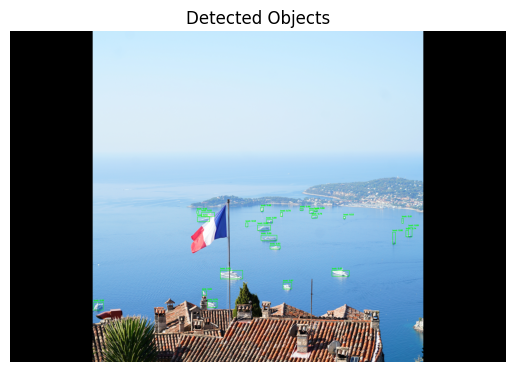

In [6]:
large_image = Image.open(path).convert("RGB").rotate(90)
TILE_SIZE = 640  # Standard YOLO input size
OVERLAP = 0


print("Tiling image...")
tiles = tile_image(large_image, TILE_SIZE, OVERLAP)
print(f"Generated {len(tiles)} tiles.")
print("Running predictions on tiles...")
all_detections = predict_on_tiles(model=model_x, tiles=tiles)
print(f"Found {len(all_detections)} total detections before NMS.")
print("Applying Non-Maximum Suppression...")
final_detections = apply_nms(all_detections, iou_threshold=0.50)
print(f"Found {len(final_detections)} unique detections after NMS.")


# Filter Detections:
# final_detections = np.array([i for i in final_detections if i[4] > 0.75])
filtered_arr = final_detections[final_detections[:, 4] > 0.50]

img_cv2 = cv2.cvtColor(np.array(large_image), cv2.COLOR_RGB2BGR)
for det in filtered_arr:
    # x1, y1, x2, y2, conf, cls = map(int, det[:6])
    x1, y1, x2, y2 = map(int, det[:4])
    conf, cls = det[4], det[5]
    label = f"{model_x.names[cls]}: {conf:.2f}"
    cv2.rectangle(img_cv2, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv2, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

show_image(img_cv2, "Detected Objects")

In [7]:
# Image.fromarray(img_cv2, 'RGB').save('DSC00304_detected.jpg')